# Nuclear Statistical Equilibrium

pynucastro is able to calculate the abundances at nuclear statistical equilibrium of a given reaction network.

The constrained equations are setup following:
* Calder et al. (2007): https://iopscience.iop.org/article/10.1086/510709/pdf
* Seitenzahl et al. (2009): https://www.sciencedirect.com/science/article/abs/pii/S0092640X0800051X

and solved using `scipy.optimize.fsolve()`

Here we show how to find the NSE state of a set of nuclei.

In [8]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt

We start by creating a `Library` object that reads all the ReacLib rates and link different nuclei of choice. Then initialize `RateCollection` by using the the rates created by the `Library` object.

In [9]:
library = pyna.ReacLibLibrary()

subch_full = library.linking_nuclei(["p", "he4",
                                     "c12", "n13", "n14",
                                     "o16", "f18", "ne20",
                                     "ne21", "na22", "na23",
                                     "mg24", "al27", "si28",
                                     "p31", "s32", "cl35",
                                     "ar36", "k39", "ca40",
                                     "sc43", "ti44", "v47",
                                     "cr48", "mn51",
                                     "fe52","co55","ni56"])

rc = pyna.RateCollection(libraries=subch_full)

`get_comp_nse(rho,T,ye)` is a method of `RateCollection` that returns composition at NSE as an object `Composition` by providing density, temperature, and a presribed electron fraction. There is pre-set initial guess, however one should adjust the initial guess, accordingly if no solutions are found or taking a long time as the algorithm is searching for the correct initial guess.

It has options of incorporating coulomb correction terms by let `use_coulomb_corr=True`, and return the solution of proton and neutron chemical potentials by `return_sol=True`.

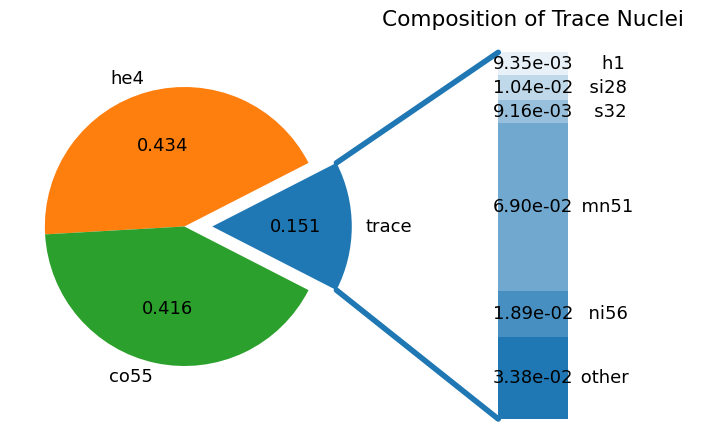

In [11]:
comp, sol = rc.get_comp_nse(1e7, 6e9, 0.50, use_coulomb_corr=True, return_sol=True)
fig = comp.plot()

We can also explicitly print the composition

In [13]:
print(comp)
print(f"After solving, the chemical potential for proton and neutron are {sol[0]} and {sol[1]}")

  X(p) : 0.009350257557755745
  X(he4) : 0.4336432648337397
  X(c12) : 7.728730855863679e-06
  X(n13) : 2.592044572072426e-10
  X(n14) : 1.366332980043754e-09
  X(o16) : 1.5697551606923965e-05
  X(f18) : 2.411406340623987e-11
  X(ne20) : 3.018748620023282e-07
  X(ne21) : 3.956328637888797e-09
  X(na22) : 9.687083066114455e-10
  X(na23) : 7.296922766617078e-08
  X(mg24) : 3.4701773454356374e-05
  X(al27) : 3.3526418310423996e-05
  X(si28) : 0.01043957131530905
  X(p31) : 0.00213499350058423
  X(s32) : 0.009160645411758385
  X(cl35) : 0.004000874822061756
  X(ar36) : 0.004879636200528169
  X(k39) : 0.005552717409027393
  X(ca40) : 0.0047698633574799545
  X(sc43) : 0.0003726846903449166
  X(ti44) : 0.00022925810669629146
  X(v47) : 0.004900622959185997
  X(cr48) : 0.0011488659730385128
  X(mn51) : 0.06904761336409458
  X(fe52) : 0.00574686874545434
  X(co55) : 0.41561537762309186
  X(ni56) : 0.018914848236755235

After solving, the chemical potential for proton and neutron are -7.73861021

For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and electron fraction, $Y_e = 0.5$, we can explore how the NSE state changes with temperature.

In [22]:
rho = 1e7
ye = 0.5
temps = np.linspace(2.5, 12.0, 100)
X_s = []

guess = [-6.0, -11.5]
for i, temp in enumerate(temps):
    nse_comp, sol = rc.get_comp_nse(rho, temp*1.0e9, ye, init_guess=guess, 
                                    use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s = [nse_comp.X[nuc] for nuc in nse_comp.X]
    X_s.append(nse_X_s)

Text(0.5, 1.0, '$Y_e = 0.5$, $\\rho =  1e+07$')

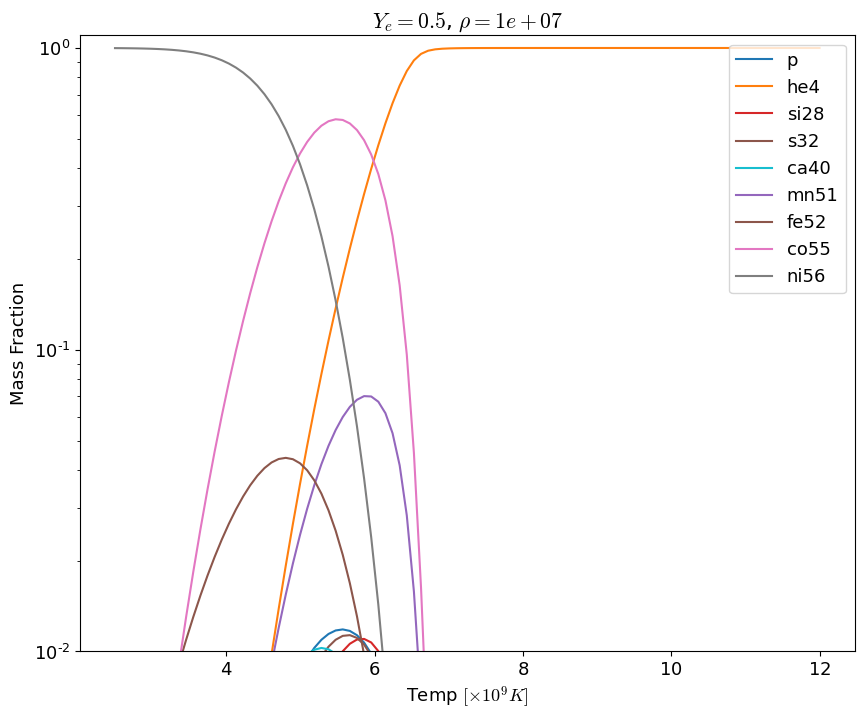

In [21]:
X_s = np.array(X_s)
nuc_names = rc.get_nuclei()

low_limit = 1e-2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for k in range(len(nuc_names)):
    line, = ax.plot(temps, X_s[:,k])
    if (max(X_s[:,k]) > low_limit):
        line.set_label(str(nuc_names[k]))

ax.legend(loc = "upper right")
ax.set_xlabel(r'Temp $[\times 10^9 K]$')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([low_limit,1.1])
ax.set_title(rf"$Y_e = {ye}$, $\rho = {rho:6.3g}$")


For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and a relatively high temperature of $ T = 6 \times 10^9~\mathrm{K}$, we can look at how the NSE state changes with varying $Y_e$.

Note: there will be a lowest $Y_e$ that is attainable by the network, depending on what species are represented.  As long as protons are in the network, we can reach a $Y_e$ of $1$.

In [23]:
ye_low = min(nuc.Z/nuc.A for nuc in rc.unique_nuclei)

In [24]:
rho = 1e7
ye_s = np.linspace(ye_low, 0.65, 100)
temp = 6.0e9
X_s_1 = []

guess = [-6.0, -11.5]
for i, ye in enumerate(ye_s):
    nse_comp_1, sol = rc.get_comp_nse(rho, temp, ye, init_guess=guess, 
                                      use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s_1 = [nse_comp_1.X[nuc] for nuc in nse_comp_1.X]
    X_s_1.append(nse_X_s_1)

Text(0.5, 1.0, '$\\rho =  1e+07$ and $T= 6e+09$')

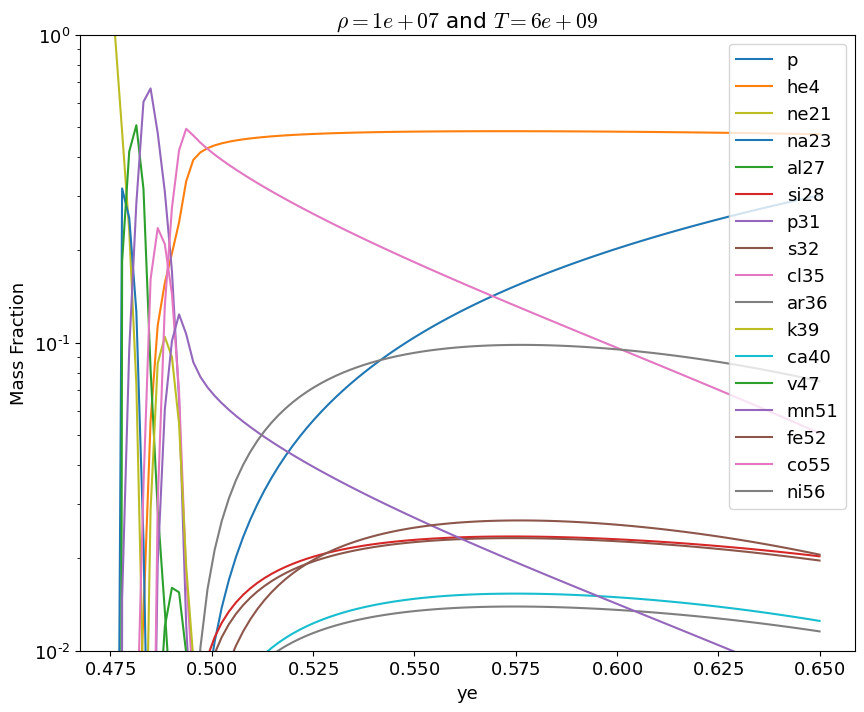

In [26]:
X_s_1 = np.array(X_s_1)
nuc_names = rc.get_nuclei()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for k in range(len(nuc_names)):
    line, = ax.plot(ye_s, X_s_1[:,k])
    if (max(X_s_1[:,k]) > 0.01):
        line.set_label(str(nuc_names[k]))
ax.legend(loc = "best")
ax.set_xlabel('ye')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([0.01,1])
ax.set_title(rf"$\rho = {rho:6.3g}$ and $T={temp:6.3g}$")